In [74]:
import pandas_datareader as pdr

In [75]:
# collecting AAPL stock data from yahoo
ticker = 'AAPL'
start_date = '2019-01-01'
end_date = '2021-12-31'

df = pdr.get_data_yahoo(ticker, start_date, end_date)

In [76]:
# save data as csv file
df.to_csv('AAPL.csv')

In [77]:
import pandas as pd
stocks = pd.read_csv('AAPL.csv')
stocks

,Date,High,Low,Open,Close,Volume,Adj Close
0,2018-12-31,39.840000,39.119999,39.632500,39.435001,140014000.0,38.282616
1,2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.326286
2,2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.508717
3,2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,35.981865
4,2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,35.901775
...,...,...,...,...,...,...,...
753,2021-12-27,180.419998,177.070007,177.089996,180.330002,74919600.0,180.330002
754,2021-12-28,181.330002,178.529999,180.160004,179.289993,79144300.0,179.289993
755,2021-12-29,180.630005,178.139999,179.330002,179.380005,62348900.0,179.380005
756,2021-12-30,180.570007,178.089996,179.470001,178.199997,59773000.0,178.199997


In [78]:
stocks['Date'] = pd.to_datetime(stocks['Date'])

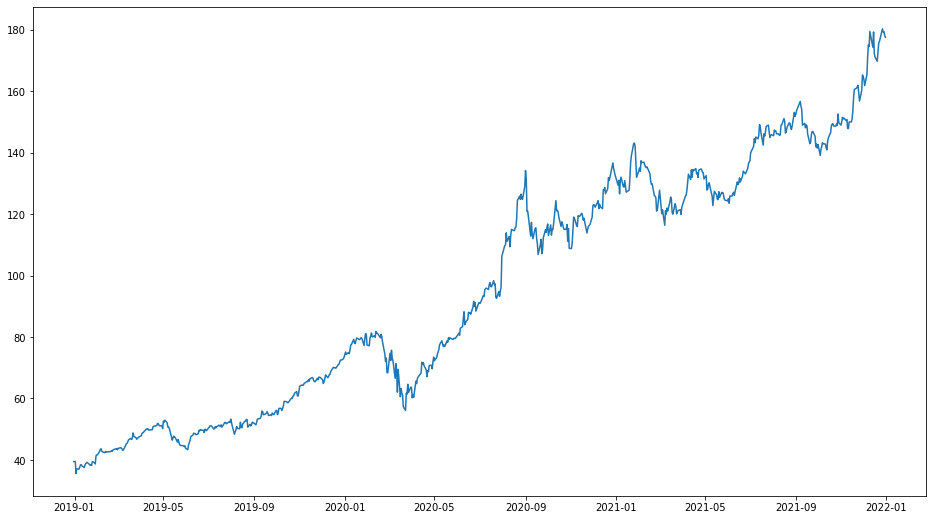

In [79]:
# Apple Inc. stock price graph (Jan'2019 to Dec'2021)

import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(stocks.Date, stocks.Close)
plt.show()

# Preprocessing

In [80]:
apple_stock = pd.DataFrame(stocks,columns=['Close'])

In [81]:
apple_stock

,Close
0,39.435001
1,39.480000
2,35.547501
3,37.064999
4,36.982498
...,...
753,180.330002
754,179.289993
755,179.380005
756,178.199997


In [82]:
type(apple_stock)

pandas.core.frame.DataFrame

In [83]:
# scaling data 

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0,1))
apple_stock_mms = mms.fit_transform(apple_stock)
apple_stock_mms

array([[0.02685063],
       [0.02716142],
       [0.        ],
       [0.01048123],
       [0.0099114 ],
       [0.01478079],
       [0.01920121],
       [0.02004731],
       [0.01743994],
       [0.01348574],
       [0.01878681],
       [0.02201578],
       [0.02360437],
       [0.02526204],
       [0.01918395],
       [0.02025451],
       [0.0181479 ],
       [0.02688514],
       [0.02436413],
       [0.02156682],
       [0.03981834],
       [0.04187315],
       [0.0420113 ],
       [0.05017871],
       [0.05523801],
       [0.05534164],
       [0.04964343],
       [0.04872827],
       [0.04703605],
       [0.04955709],
       [0.0483311 ],
       [0.04940169],
       [0.04874552],
       [0.04962615],
       [0.05152556],
       [0.04985063],
       [0.05314869],
       [0.05532435],
       [0.05549704],
       [0.05642946],
       [0.05345948],
       [0.05660214],
       [0.05812167],
       [0.05756911],
       [0.05582512],
       [0.05233712],
       [0.05304509],
       [0.063

In [84]:
# Spliting data for checking the model validity after prediction

training_size = int(len(apple_stock_mms)*0.8)
train_data, test_data = apple_stock_mms[:training_size, :], apple_stock_mms[training_size:, :]

In [85]:
train_data.shape, test_data.shape

((606, 1), (152, 1))

In [86]:
# Creating input and output set

import numpy as np
def create_dataset(dataset, timestep):
    x = []
    y = []
    for i in range(len(dataset)-timestep):
        x.append(dataset[i:(timestep+i), 0])
        y.append(dataset[(timestep+i), 0])
    return np.array(x), np.array(y)

In [87]:
# I will train the model on the basis of past 30 days data
timestep = 30
x_train, y_train = create_dataset(train_data, timestep)
x_test, y_test = create_dataset(test_data, timestep)

In [88]:
x_train.shape, y_train.shape

((576, 30), (576,))

In [89]:
x_test.shape, y_test.shape

((122, 30), (122,))

In [90]:
# reshaping input data into 3D array for LSTM layer

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Building Model

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [109]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units= hp.Int('neurons',min_value=16, max_value=256, step=32), input_shape=(timestep,1), return_sequences=True))
    for i in range(hp.Int('hidden_layers', min_value=2, max_value=8)):
        model.add(LSTM(units= hp.Int('neurons'+str(i), min_value=16, max_value=128, step=16), return_sequences=True))
    model.add(LSTM(units= hp.Int('neurons_', min_value=16, max_value=128, step=16)))
    model.add(Dense(units=1))
              
    model.compile(optimizer = Adam(learning_rate = hp.Choice('lr', [1e-2, 1e-3, 1e-4])), loss = 'mse', metrics = ['mean_squared_error'])
    return model

In [110]:
import keras_tuner
from keras_tuner import RandomSearch

In [112]:
tuner_search = RandomSearch(build_model, objective = 'val_mean_squared_error', max_trials=10, executions_per_trial=1)

In [113]:
# search best parameters for train-set (and checking validation of those parameters for test-set)

tuner_search.search(x_train, y_train, validation_data=(x_test,y_test), epochs=20, batch_size=64)

Trial 10 Complete [00h 00m 41s]
val_mean_squared_error: 0.07507123798131943

Best val_mean_squared_error So Far: 0.0016462195198982954
Total elapsed time: 00h 05m 43s
INFO:tensorflow:Oracle triggered exit


In [114]:
best_model = tuner_search.get_best_models(num_models=1)[0]

In [115]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 112)           51072     
                                                                 
 lstm_1 (LSTM)               (None, 30, 96)            80256     
                                                                 
 lstm_2 (LSTM)               (None, 30, 80)            56640     
                                                                 
 lstm_3 (LSTM)               (None, 30, 96)            67968     
                                                                 
 lstm_4 (LSTM)               (None, 80)                56640     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 312,657
Trainable params: 312,657
Non-trai

# Predicting stock price

In [116]:
# Predicting for both train and test set (trained only on train-set)

train_pred = best_model.predict(x_train)
test_pred = best_model.predict(x_test)

2022-01-04 12:32:45.854581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:46.139990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:46.367011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:46.659670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:46.915252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:47.160837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 12:32:48.678268: I tensorflow/core/grappler/optimizers/cust

In [117]:
# inverse scaling (to get the predicted price values)

train_pred = mms.inverse_transform(train_pred)
test_pred = mms.inverse_transform(test_pred)

In [134]:
# Checking RMSE of the predicted data (to understand difference between real and predicted data)

from sklearn.metrics import mean_squared_error
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, train_pred)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_test, test_pred)))

Train RMSE:  92.01659750619555
Test RMSE:  154.6502128043973


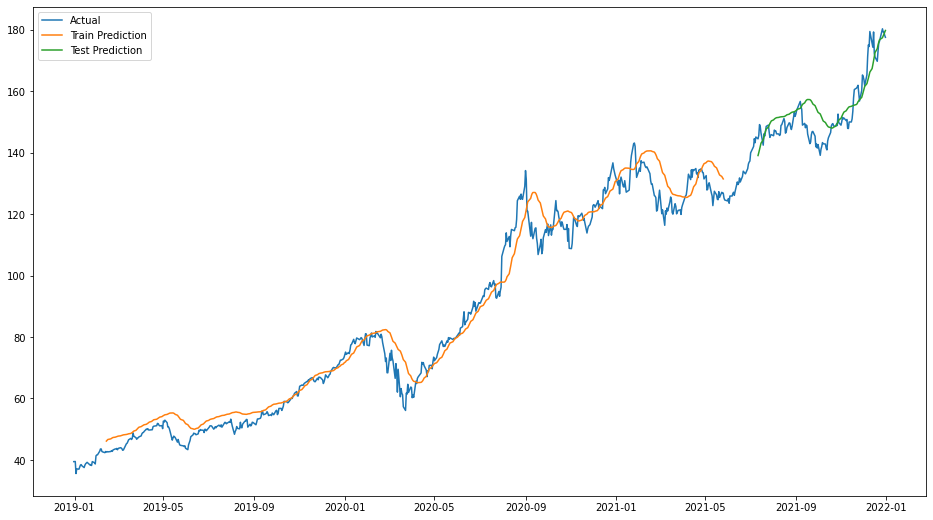

In [119]:
# Plotting Real and Predicted data

plt.figure(figsize = (16,9))
plt.plot(stocks['Date'], stocks['Close'], label = 'Actual')
plt.plot(stocks['Date'].to_list()[timestep:training_size],train_pred, label = 'Train Prediction')
plt.plot(stocks['Date'].to_list()[training_size+timestep:], test_pred, label = 'Test Prediction')
plt.legend()
plt.show()

# Prediction for next 30 days

In [127]:
pred_days = 30

# creating input data for the prediction
train_data_new = apple_stock_mms[-timestep:, :]

In [128]:
train_data_new.shape

(30, 1)

In [129]:
type(train_data_new)

numpy.ndarray

In [130]:
prediction = []

for i in range(pred_days):
    # converting input data-set for prediction
    train_data_new = np.array(train_data_new).reshape(1,timestep,1)
    # predict stock price of a single day
    y_pred_new = best_model.predict(train_data_new)[0][0]
    
    # collecting predicted values in a list
    prediction.append(y_pred_new)
    
    # converting input data-set into list (to append predicted value for next day's prediction) 
    train_data_new = train_data_new[0,:,0].tolist()
    train_data_new.append(y_pred_new)
    
    # removing 1st data from input data-set (because last predicted value already added to the end)
    train_data_new = train_data_new[1:]

In [131]:
# predicted Scaled stock prices for next 30 days 
prediction

[1.0254565,
 1.0296783,
 1.0340899,
 1.0388439,
 1.0440149,
 1.0496082,
 1.0556226,
 1.061906,
 1.0683738,
 1.0750066,
 1.0817453,
 1.0885512,
 1.0953487,
 1.1021096,
 1.108853,
 1.1156157,
 1.1223475,
 1.1291262,
 1.1359197,
 1.1426722,
 1.1494921,
 1.1563119,
 1.1631327,
 1.1699139,
 1.1766676,
 1.1834158,
 1.1901269,
 1.1968492,
 1.2035662,
 1.2102829]

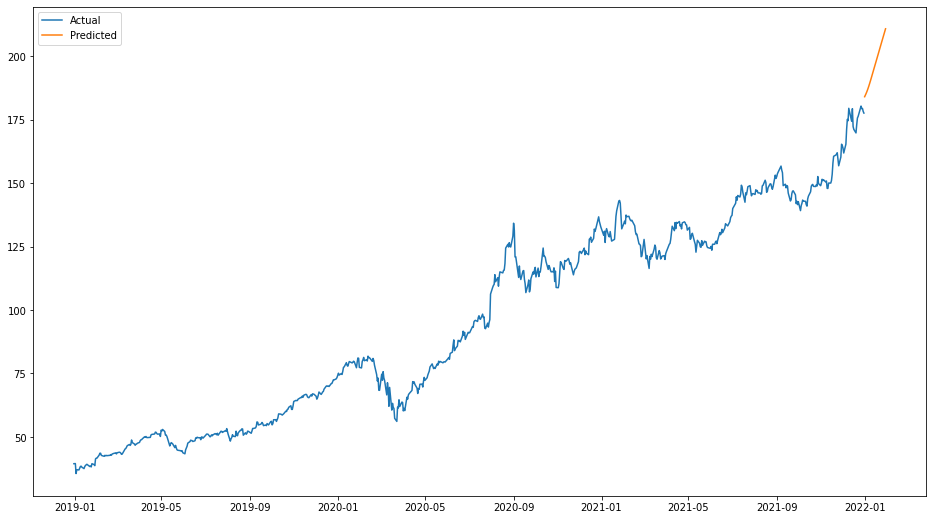

In [132]:
# plotting Real and Predicted data
pred_dates = pd.date_range(start = '2022-01-01', periods = pred_days)

prediction = np.array(prediction).reshape(-1,1)
prediction = mms.inverse_transform(prediction)

plt.figure(figsize = (16,9))
plt.plot(stocks['Date'], stocks['Close'], label = 'Actual')
plt.plot(pred_dates, prediction, label = 'Predicted')
plt.legend()
plt.show()

In [133]:
# predicted stock prices for next 30 days
prediction

array([[184.01567],
       [184.6269 ],
       [185.26562],
       [185.95392],
       [186.70259],
       [187.5124 ],
       [188.38318],
       [189.29291],
       [190.22932],
       [191.18965],
       [192.16528],
       [193.15067],
       [194.13483],
       [195.11368],
       [196.09001],
       [197.06914],
       [198.04378],
       [199.0252 ],
       [200.00879],
       [200.98643],
       [201.97385],
       [202.96123],
       [203.94876],
       [204.93056],
       [205.90837],
       [206.88539],
       [207.85706],
       [208.83032],
       [209.80283],
       [210.77528]], dtype=float32)

# Today(2022-01-04) AAPL stock price- 
# Real 182.01, Predicted 185.95
# the prediction is really close to real value and real price is also going up as predicted graph.